# Feature Engineering - Quantum Finance Dataset
Neste notebook, vamos aplicar diversas técnicas de Feature Engineering no dataset fornecido.

### Técnicas que serão abordadas:
- Label Encoding
- One-Hot Encoding
- Frequency Encoding
- Ordinal Encoding
- Binary Encoding
- PCA
- t-SNE
- SMOTE
- Feature Selection (Filtros, Wrappers e Embedded)
- RandomForestRegressor

Importação das bibliotecas

In [1]:
!pip install pandas numpy scikit-learn matplotlib seaborn nltk imbalanced-learn



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# PCA (Principal Component Analysis) é usado para reduzir a dimensionalidade dos dados.
# **Trade-off**: Reduz a quantidade de variáveis ao combinar variáveis correlacionadas, mas perde a interpretabilidade das features originais.
# Útil para eliminar redundância, mas pode dificultar a explicação dos resultados se os componentes não forem claramente relacionados às variáveis originais.

# Importação das bibliotecas
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fspo1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 1. Carregamento dos Dados

In [3]:
# Carregamento do dataset
dataset_path = 'Base_ScoreCredito_QuantumFinance.csv'
df = pd.read_csv(dataset_path, delimiter=';')
df.head()

,id,idade,sexo,estado_civil,escola,Qte_dependentes,tempo_ultimoservico,trabalha,vl_salario_mil,reg_moradia,casa_propria,vl_imovel_em_mil,Qte_cartoes,Qte_carros,SCORE_CREDITO
0,708082083,45,F,casado,graduacao,3,40,1,"40,089665024322",3,0,0,1,1,778
1,708083283,58,M,solteiro,ensino fundam,0,44,1,"66,557645274838",3,0,0,1,0,"276,3"
2,708084558,46,M,divorciado,doutorado,3,35,1,"123,68182089138",6,0,0,1,1,401
3,708085458,34,F,solteiro,mestrado,0,22,1,"19,7159343168329",6,0,0,1,0,"347,4"
4,708086958,49,F,casado,mestrado,2,36,0,0,3,1,437,1,2,476


## 2. Tratamento Inicial dos Dados
Vamos tratar valores ausentes e ajustar tipos de dados.

In [4]:
# Tratamento de dados

# Preencher valores ausentes nas colunas numéricas com a mediana
df = df.apply(lambda x: x.fillna(x.median()) if x.dtype != 'object' else x)

# Preencher valores ausentes nas colunas categóricas com 'Desconhecido'
df = df.apply(lambda x: x.fillna('Desconhecido') if x.dtype == 'object' else x)

# Converter a coluna 'vl_salario_mil' para float, substituindo vírgulas por pontos
df['vl_salario_mil'] = df['vl_salario_mil'].apply(lambda x: float(str(x).replace(',', '.')))

# Converter a coluna 'SCORE_CREDITO' para float, substituindo vírgulas por pontos
df['SCORE_CREDITO'] = df['SCORE_CREDITO'].apply(lambda x: float(str(x).replace(',', '.')))

# Filtrar para remover valores não realistas
df = df[(df['SCORE_CREDITO'] > 0) & (df['vl_salario_mil'] >= 0)]

# Verificar a informação do DataFrame após o tratamento
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   10127 non-null  int64  
 1   idade                10127 non-null  int64  
 2   sexo                 10127 non-null  object 
 3   estado_civil         10127 non-null  object 
 4   escola               10127 non-null  object 
 5   Qte_dependentes      10127 non-null  int64  
 6   tempo_ultimoservico  10127 non-null  int64  
 7   trabalha             10127 non-null  int64  
 8   vl_salario_mil       10127 non-null  float64
 9   reg_moradia          10127 non-null  int64  
 10  casa_propria         10127 non-null  int64  
 11  vl_imovel_em_mil     10127 non-null  int64  
 12  Qte_cartoes          10127 non-null  int64  
 13  Qte_carros           10127 non-null  int64  
 14  SCORE_CREDITO        10127 non-null  float64
dtypes: float64(2), int64(10), object(3)


## 3. Label Encoding

In [5]:
# Label Encoding é útil para transformar variáveis categóricas em números inteiros.
# Isso é vantajoso para modelos que não conseguem lidar com strings diretamente.
# **Trade-off**: O Label Encoding pode induzir o modelo a interpretar que existe uma ordem entre as categorias, o que pode não ser verdade.
# Portanto, é importante garantir que o algoritmo utilizado seja capaz de lidar com essa codificação de forma adequada.

# Aplicar Label Encoding
label_enc = LabelEncoder()
df['estado_civil_encoded'] = label_enc.fit_transform(df['estado_civil'])
df[['estado_civil', 'estado_civil_encoded']].head()

,estado_civil,estado_civil_encoded
0,casado,0
1,solteiro,3
2,divorciado,1
3,solteiro,3
4,casado,0


## 4. One-Hot Encoding

In [6]:
# O One-Hot Encoding transforma categorias em colunas binárias, onde cada coluna representa uma categoria.
# **Trade-off**: A vantagem é que não impõe nenhuma ordem implícita às categorias, mas o problema é que pode aumentar muito a dimensionalidade dos dados, especialmente quando temos muitas categorias.
# Isso pode levar a um aumento no tempo de treinamento e à necessidade de mais recursos computacionais.

# Aplicar One-Hot Encoding
df = pd.get_dummies(df, columns=['sexo', 'escola'], drop_first=True)
df.head()

,id,idade,estado_civil,Qte_dependentes,tempo_ultimoservico,trabalha,vl_salario_mil,reg_moradia,casa_propria,vl_imovel_em_mil,Qte_cartoes,Qte_carros,SCORE_CREDITO,estado_civil_encoded,sexo_M,escola_ensino fundam,escola_ensino medio,escola_graduacao,escola_mestrado
0,708082083,45,casado,3,40,1,40.089665,3,0,0,1,1,778.0,0,False,False,False,True,False
1,708083283,58,solteiro,0,44,1,66.557645,3,0,0,1,0,276.3,3,True,True,False,False,False
2,708084558,46,divorciado,3,35,1,123.681821,6,0,0,1,1,401.0,1,True,False,False,False,False
3,708085458,34,solteiro,0,22,1,19.715934,6,0,0,1,0,347.4,3,False,False,False,False,True
4,708086958,49,casado,2,36,0,0.000000,3,1,437,1,2,476.0,0,False,False,False,False,True


## 5. Frequency Encoding

In [7]:
# Frequency Encoding substitui as categorias pela frequência de cada categoria.
# **Trade-off**: Captura a distribuição das categorias, mas não leva em conta a importância relativa de cada uma.
# Pode ser útil quando há muitas categorias únicas e queremos compactar a informação sem usar One-Hot Encoding.

# Aplicar Frequency Encoding
frequency_map = df['estado_civil'].value_counts(normalize=True)
df['estado_civil_frequency'] = df['estado_civil'].map(frequency_map)
df[['estado_civil', 'estado_civil_frequency']].head()

,estado_civil,estado_civil_frequency
0,casado,0.462822
1,solteiro,0.389355
2,divorciado,0.073862
3,solteiro,0.389355
4,casado,0.462822


## 6. Ordinal Encoding

In [8]:
# Ordinal Encoding transforma categorias em números inteiros baseados em uma ordem específica.
# **Trade-off**: É útil quando existe uma ordem natural entre as categorias (por exemplo, nível de escolaridade).
# O problema é que assume que a distância entre as categorias é uniforme, o que pode não ser verdade na prática.

# Criar uma nova coluna 'escola' combinando as colunas de One-Hot Encoding
# Para cada linha, verificar qual coluna One-Hot é True e atribuir o respectivo valor categórico

def get_escolaridade(row):
    if row['escola_ensino fundam']:
        return 'ensino fundam'
    elif row['escola_ensino medio']:
        return 'ensino medio'
    elif row['escola_graduacao']:
        return 'graduacao'
    elif row['escola_mestrado']:
        return 'mestrado'
    else:
        return 'Desconhecido'

# Criar a coluna 'escola' a partir das colunas de One-Hot
df['escola'] = df.apply(get_escolaridade, axis=1)

# Aplicar Ordinal Encoding na nova coluna 'escola'
ord_enc = OrdinalEncoder(categories=[['Desconhecido', 'ensino fundam', 'ensino medio', 'graduacao', 'mestrado']])
df['escola_ordinal'] = ord_enc.fit_transform(df[['escola']])

# Visualizar as primeiras linhas do DataFrame com a nova coluna ordinal
df[['escola', 'escola_ordinal']].head()


,escola,escola_ordinal
0,graduacao,3.0
1,ensino fundam,1.0
2,Desconhecido,0.0
3,mestrado,4.0
4,mestrado,4.0


## 7. Binary Encoding

In [9]:
# Binary Encoding combina características do One-Hot e do Label Encoding.
# **Trade-off**: Reduz a dimensionalidade em relação ao One-Hot, mas mantém a informação das categorias originais.
# Contudo, pode ser mais difícil de interpretar, especialmente para categorias com muitos níveis.

# Aplicar Binary Encoding
df['trabalha_binary'] = df['trabalha'].apply(lambda x: 1 if x == 1 else 0)
df[['trabalha', 'trabalha_binary']].head()

,trabalha,trabalha_binary
0,1,1
1,1,1
2,1,1
3,1,1
4,0,0


## 8. PCA (Principal Component Analysis)

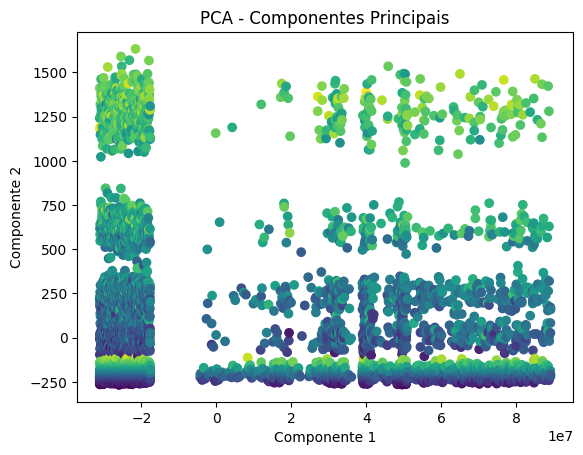

In [10]:
# PCA (Principal Component Analysis) é usado para reduzir a dimensionalidade dos dados.
# **Trade-off**: Reduz a quantidade de variáveis ao combinar variáveis correlacionadas, mas perde a interpretabilidade das features originais.
# Útil para eliminar redundância, mas pode dificultar a explicação dos resultados se os componentes não forem claramente relacionados às variáveis originais.

# Aplicar PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df.select_dtypes(include=['float64', 'int64']))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=df['SCORE_CREDITO'], cmap='viridis')
plt.title('PCA - Componentes Principais')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.show()

## 9. t-SNE

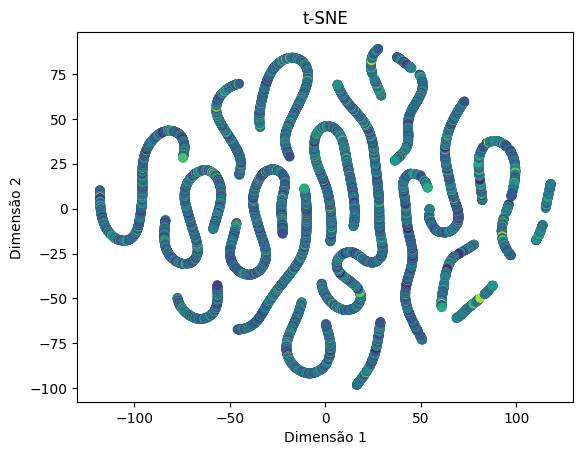

In [11]:
# t-SNE é usado principalmente para visualização de dados em alta dimensionalidade.
# **Trade-off**: Preserva relações locais, mas não preserva relações globais. 
# Isso significa que ele é ótimo para entender clusters locais, mas não deve ser usado para tarefas como classificação ou regressão.
# Além disso, tem um alto custo computacional e pode ser difícil de ajustar corretamente.

# Aplicar t-SNE
tsne = TSNE(n_components=2)
df_tsne = tsne.fit_transform(df.select_dtypes(include=['float64', 'int64']))
plt.scatter(df_tsne[:, 0], df_tsne[:, 1], c=df['SCORE_CREDITO'], cmap='viridis')
plt.title('t-SNE')
plt.xlabel('Dimensão 1')
plt.ylabel('Dimensão 2')
plt.show()

## 10. SMOTE (Synthetic Minority Over-sampling Technique)

In [16]:
# SMOTE (Synthetic Minority Over-sampling Technique) é utilizado para balancear o dataset gerando amostras sintéticas para a classe minoritária.
# **Trade-off**: Pode ajudar a melhorar a performance de modelos em datasets desbalanceados, mas, se aplicado de forma inadequada, pode levar ao overfitting.
# Além disso, a criação de dados sintéticos pode não refletir corretamente a distribuição real dos dados.

from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

# Definir o DataFrame df corretamente antes de iniciar
# Certifique-se que o 'df' contém as colunas corretas

# Definir X e y_bin
X = df.drop('SCORE_CREDITO', axis=1)  # Todas as features exceto a coluna alvo
y_bin = (df['SCORE_CREDITO'] > df['SCORE_CREDITO'].median()).astype(int)  # Converter a variável alvo para binário

# Converter variáveis categóricas para numéricas usando Label Encoding
label_enc = LabelEncoder()
for col in X.select_dtypes(include=['object']).columns:
    X[col] = label_enc.fit_transform(X[col])

# Aplicar SMOTE para balancear o dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y_bin)

# Verificar a nova forma dos dados
print(f"Formato original: {X.shape}, {y_bin.shape}")
print(f"Formato resampleado: {X_resampled.shape}, {y_resampled.shape}")



Formato original: (10127, 22), (10127,)
Formato resampleado: (10128, 22), (10128,)


## 11. Feature Selection -  Opção 1: Transformar y em Binário para Classificação

In [17]:
# A seleção de features é crucial para melhorar a performance do modelo e reduzir a complexidade.
# **Trade-off**: Métodos baseados em filtros (como SelectKBest) não consideram interações entre variáveis, enquanto métodos como Wrappers (RandomForest) são mais custosos computacionalmente.
# A escolha do método depende do objetivo e do recurso computacional disponível.

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np

# Transformar a variável alvo em binária com base na mediana
y_bin = (df['SCORE_CREDITO'] > df['SCORE_CREDITO'].median()).astype(int)

# Criar uma cópia de X para realizar transformações
X = df.drop('SCORE_CREDITO', axis=1).copy()

# Converter colunas categóricas para numéricas usando LabelEncoder
label_enc = LabelEncoder()
for col in X.select_dtypes(include=['object']).columns:
    X[col] = label_enc.fit_transform(X[col])

# Garantir que todas as variáveis numéricas sejam não-negativas (importante para chi2)
for col in X.select_dtypes(include=['float64', 'int64']).columns:
    if X[col].min() < 0:
        X[col] = X[col] + abs(X[col].min()) + 1

# Verificar e remover colunas que contenham valores NaN ou infinitos
X = X.replace([np.inf, -np.inf], np.nan)  # Substituir valores infinitos por NaN
X = X.dropna(axis=1, how='any')  # Remover colunas com qualquer NaN

# Aplicar SelectKBest com chi2
selector = SelectKBest(chi2, k=5)
X_new = selector.fit_transform(X, y_bin)
print('Melhores Features (Filtros):', X.columns[selector.get_support()])

# Aplicar RandomForest para seleção de features com a variável binária
model = RandomForestClassifier(random_state=42)
model.fit(X, y_bin)
print('Importância das Features (Wrapper - Classificação):', pd.Series(model.feature_importances_, index=X.columns).nlargest(5))

Melhores Features (Filtros): Index(['id', 'idade', 'tempo_ultimoservico', 'vl_salario_mil',
       'vl_imovel_em_mil'],
      dtype='object')
Importância das Features (Wrapper - Classificação): vl_salario_mil         0.236158
tempo_ultimoservico    0.128323
vl_imovel_em_mil       0.113463
idade                  0.106570
id                     0.098889
dtype: float64


## 12. Opção 2: Usar RandomForestRegressor para Regressão

In [18]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np

# Manter y como variável contínua
y = df['SCORE_CREDITO']

# Criar uma cópia de X para realizar transformações
X = df.drop('SCORE_CREDITO', axis=1).copy()

# Converter colunas categóricas para numéricas usando LabelEncoder
label_enc = LabelEncoder()
for col in X.select_dtypes(include=['object']).columns:
    X[col] = label_enc.fit_transform(X[col])

# Garantir que todas as variáveis numéricas sejam não-negativas (importante para chi2)
for col in X.select_dtypes(include=['float64', 'int64']).columns:
    if X[col].min() < 0:
        X[col] = X[col] + abs(X[col].min()) + 1

# Verificar e remover colunas que contenham valores NaN ou infinitos
X = X.replace([np.inf, -np.inf], np.nan)  # Substituir valores infinitos por NaN
X = X.dropna(axis=1, how='any')  # Remover colunas com qualquer NaN

# Aplicar SelectKBest com f_regression para regressão
selector = SelectKBest(f_regression, k=5)
X_new = selector.fit_transform(X, y)
print('Melhores Features (Filtros):', X.columns[selector.get_support()])

# Aplicar RandomForestRegressor para prever a variável contínua
model = RandomForestRegressor(random_state=42)
model.fit(X, y)
print('Importância das Features (Wrapper - Regressão):', pd.Series(model.feature_importances_, index=X.columns).nlargest(5))


Melhores Features (Filtros): Index(['tempo_ultimoservico', 'vl_salario_mil', 'reg_moradia',
       'vl_imovel_em_mil', 'Qte_cartoes'],
      dtype='object')
Importância das Features (Wrapper - Regressão): vl_imovel_em_mil       0.345916
vl_salario_mil         0.276517
tempo_ultimoservico    0.113780
Qte_carros             0.060046
idade                  0.055836
dtype: float64


## 13. Conclusão
Neste notebook, exploramos várias técnicas de Feature Engineering aplicáveis ao dataset Quantum Finance. Essas técnicas ajudam a transformar e selecionar as variáveis de maneira que melhorem a performance de modelos de Machine Learning.
### Próximos Passos
Treinar modelos de Machine Learning usando as features geradas e avaliar os resultados.

Novos valores únicos em y_pred_class: [0 1]


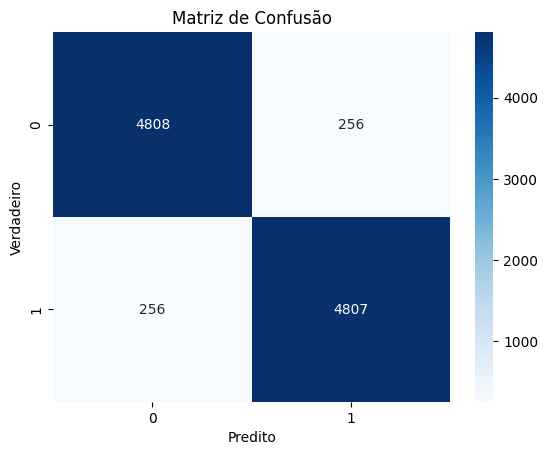

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95      5064
           1       0.95      0.95      0.95      5063

    accuracy                           0.95     10127
   macro avg       0.95      0.95      0.95     10127
weighted avg       0.95      0.95      0.95     10127



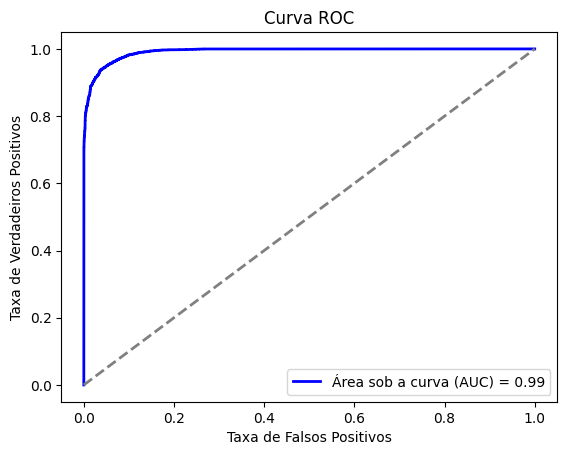

In [20]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc  # Importar as métricas necessárias
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Gerar previsões contínuas
y_pred_continuo = model.predict(X)

# Definir um limiar para converter em classes binárias
threshold = np.median(y_pred_continuo)  # Por exemplo, usar a mediana como limiar
y_pred_class = (y_pred_continuo > threshold).astype(int)

# Verificar os novos valores de y_pred_class
print(f"Novos valores únicos em y_pred_class: {np.unique(y_pred_class)}")

# Matriz de Confusão
cm = confusion_matrix(y_bin, y_pred_class)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

# Relatório de Classificação
print("Relatório de Classificação:\n", classification_report(y_bin, y_pred_class))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_bin, y_pred_continuo)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Área sob a curva (AUC) = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()
